# Finetuning Llama 3.2 3B

In [ ]:
# Title: Fine-tuning Llama 3.2 3B on MotionSense Data and Evaluating Poisoning Detection
# Install dependencies
%%capture
!pip install unsloth pandas numpy scikit-learn matplotlib seaborn datasets transformers trl torch accelerate
# Get the latest nightly Unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Import necessary libraries
import unsloth
from unsloth import FastLanguageModel
from google.colab import drive
import os
import torch
import pandas as pd
from datasets import Dataset
from transformers import TrainingArguments, DataCollatorForSeq2Seq, pipeline
from trl import SFTTrainer
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, confusion_matrix
import json
import numpy as np

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
# 1. Mount Google Drive
drive.mount('/content/drive')
HOME = '/content/drive/MyDrive/Motionsense Dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 3. Paths and parameters
CSV_PATH = os.path.join(HOME, 'combined_motionsense.csv')
POISONED_PATH = os.path.join(HOME, 'poisoned.csv')
GROUND_TRUTH_PATH = os.path.join(HOME, 'ground_truth.csv')
OUTPUT_DIR = os.path.join(HOME, 'llama3.2_finetuned')
REPORT_JSON = os.path.join(HOME, 'llama3.2-3b_finetuned_eval_report.json')

MAX_SEQ_LENGTH = 2048
SAMPLE_SIZE = 500
BATCH_SIZE = 2
LR = 2e-4
EPOCHS = 3
SEED = 42

sensor_cols = [
    'attitude.roll','attitude.pitch','attitude.yaw',
    'gravity.x','gravity.y','gravity.z',
    'rotationRate.x','rotationRate.y','rotationRate.z',
    'userAcceleration.x','userAcceleration.y','userAcceleration.z'
]
LABEL_COL = 'Label'

In [ ]:
# 4. Load and sample data
df = pd.read_csv(CSV_PATH)
train_df = df.sample(n=SAMPLE_SIZE, random_state=SEED).reset_index(drop=True)

# Load poisoned dataset and ground truth for evaluation
poisoned_df = pd.read_csv(POISONED_PATH)
ground_truth_df = pd.read_csv(GROUND_TRUTH_PATH)

# Merge to get poisoning information
eval_df = poisoned_df.merge(ground_truth_df, left_index=True, right_index=True, suffixes=('_poisoned', '_true'))
eval_df['is_poisoned'] = eval_df['Label_poisoned'] != eval_df['Label_true']

print(f"Training data shape: {train_df.shape}")
print(f"Evaluation data shape: {eval_df.shape}")
print(f"Number of poisoned samples: {eval_df['is_poisoned'].sum()}")

Training data shape: (500, 14)
Evaluation data shape: (200, 31)
Number of poisoned samples: 80


In [ ]:
# Format prompts
def format_prompt(row, few_shot_examples=None):
    prompt = ''
    if few_shot_examples:
        for ex_text, ex_label in few_shot_examples:
            prompt += ex_text + f" {ex_label}\n---\n"
    features = ", ".join([f"{c}: {row[c]}" for c in sensor_cols])
    return prompt + f"Sensor readings: {features}\nActivity:"

train_df['text'] = train_df.apply(lambda r: format_prompt(r), axis=1)
train_df['label_text'] = train_df[LABEL_COL]


In [ ]:
# 5. Initialize model - Updated with proper device settings
# Check if CUDA is available and set device appropriately
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set dtype properly based on hardware
if torch.cuda.is_available():
    dtype = torch.float16
    load_in_4bit = True if torch.cuda.get_device_properties(0).total_memory > 16e9 else False
    print(f"Using dtype: {dtype}, 4bit: {load_in_4bit}")
else:
    dtype = None
    load_in_4bit = False
    print("Using CPU, so dtype is None and not using 4bit")

# Load the model with explicit device placement
model_name = 'unsloth/Llama-3.2-3B'
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=MAX_SEQ_LENGTH,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
    device_map="auto"  # This helps with proper device placement
)

# Update the model with LoRA adapters
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,
    use_gradient_checkpointing="unsloth",
    bias="none"  # Explicitly set bias to avoid certain issues
)

# Make sure tokenizer has pad_token set correctly
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

Using device: cuda
Using dtype: torch.float16, 4bit: False
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

Unsloth 2025.3.19 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [ ]:
# 6. Prepare HF dataset
# Format prompts - update this function to be clearer
def format_prompt(row):
    features = ", ".join([f"{c}: {row[c]}" for c in sensor_cols])
    return f"Sensor readings: {features}\nActivity:"

def format_training_sample(row):
    # Input text - what the model sees
    input_text = format_prompt(row)
    # Output text - what the model should generate
    output_text = row[LABEL_COL]
    return {
        "input": input_text,
        "output": output_text
    }

# Apply the formatting to create input/output pairs
formatted_data = []
for _, row in train_df.iterrows():
    formatted_data.append(format_training_sample(row))

# Create a new Dataset with proper format for instruction tuning
train_dataset = Dataset.from_list(formatted_data)

# The SFTTrainer requires specific formatting
def formatting_func(examples):
    texts = []
    for i in range(len(examples["input"])):
        # Format as: <s>Input Output</s>
        # The input already ends with "Activity:", so just append the label
        text = f"<s>{examples['input'][i]} {examples['output'][i]}</s>"
        texts.append(text)
    return {"text": texts}

# Apply the formatting
train_dataset = train_dataset.map(formatting_func, batched=True, remove_columns=train_dataset.column_names)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
# 7. Training
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    fp16=torch.cuda.is_available(),
    logging_steps=10,
    save_strategy='steps',
    save_steps=100,
    save_total_limit=3,
    report_to='none',
    seed=SEED
)

# Setup the trainer with the properly formatted dataset
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    dataset_text_field="text",  # Use the formatted text field
    max_seq_length=MAX_SEQ_LENGTH,
    args=args,
    packing=False  # Disable packing to avoid dimension issues
)

trainer.train()
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/500 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 500 | Num Epochs = 3 | Total steps = 186
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 24,313,856/3,237,063,680 (0.75% trained)


Step,Training Loss
10,1.785000
20,1.427400
30,1.402600
40,1.378100
50,1.317200
60,1.296500
70,1.286700
80,1.309800
90,1.256200
100,1.277600


('/content/drive/MyDrive/Motionsense Dataset/llama3.2_finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/Motionsense Dataset/llama3.2_finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/Motionsense Dataset/llama3.2_finetuned/tokenizer.json')

In [ ]:
# 8. Use the already fine-tuned model for evaluation
# No need to reload the model as it's already in memory after training
print("Using the fine-tuned model that's already loaded in memory")

# Rename the variables for clarity in the rest of the code
ft_model = model
ft_tokenizer = tokenizer

Using the fine-tuned model that's already loaded in memory


In [ ]:
# Cell 9: Update the prompt functions (Detection) for Base Model

# Ensure sensor_cols_updated is defined correctly from the previous cell's output
# Example definition (should match your previous cell's output):
sensor_cols_updated = [
    'attitude.roll_poisoned', 'attitude.pitch_poisoned', 'attitude.yaw_poisoned',
    'gravity.x_poisoned', 'gravity.y_poisoned', 'gravity.z_poisoned',
    'rotationRate.x_poisoned', 'rotationRate.y_poisoned', 'rotationRate.z_poisoned',
    'userAcceleration.x_poisoned', 'userAcceleration.y_poisoned', 'userAcceleration.z_poisoned'
]
print("Using sensor columns:", sensor_cols_updated) # Verify this list is correct

def format_zero_shot_prompt(row):
    """Format a zero-shot prompt for poisoning detection (Base Model)"""
    # Check if necessary columns exist in the row
    required_cols = sensor_cols_updated + ['Label_poisoned']
    if not all(col in row for col in required_cols):
        raise ValueError(f"Missing required columns in row for zero-shot prompt. Need: {required_cols}, Have: {row.index.tolist()}")

    features = ", ".join([f"{c.replace('_poisoned', '')}: {row[c]}" for c in sensor_cols_updated])
    # Rephrase for completion
    prompt = f"""Determine if the label is poisoned given the sensor readings.
Sensor readings: {features}
Provided label: {row['Label_poisoned']}

Is this label poisoned? (Yes/No):""" # Encourage completion
    return prompt

def format_few_shot_prompt(row):
    """Format a few-shot prompt for poisoning detection with examples (Base Model)"""
    # Check if necessary columns exist in the row
    required_cols = sensor_cols_updated + ['Label_poisoned']
    if not all(col in row for col in required_cols):
        raise ValueError(f"Missing required columns in row for few-shot prompt. Need: {required_cols}, Have: {row.index.tolist()}")

    # Create few-shot examples (3 correct, 3 poisoned) - Content remains the same
    few_shot_examples = [
        # Correct examples
        {"features": "attitude.roll: 0.12, attitude.pitch: -0.05, attitude.yaw: 0.78, gravity.x: 0.01, gravity.y: 0.02, gravity.z: 0.99, rotationRate.x: 0.1, rotationRate.y: 0.2, rotationRate.z: 0.05, userAcceleration.x: 0.8, userAcceleration.y: 1.2, userAcceleration.z: 0.3",
         "label": "walking",
         "poisoned": "No"},
        {"features": "attitude.roll: -0.02, attitude.pitch: 0.01, attitude.yaw: 0.15, gravity.x: 0.0, gravity.y: 0.01, gravity.z: 1.0, rotationRate.x: 0.01, rotationRate.y: 0.02, rotationRate.z: 0.01, userAcceleration.x: 0.01, userAcceleration.y: 0.02, userAcceleration.z: 0.01",
         "label": "sitting",
         "poisoned": "No"},
        {"features": "attitude.roll: 0.25, attitude.pitch: -0.15, attitude.yaw: 0.85, gravity.x: 0.05, gravity.y: 0.1, gravity.z: 0.98, rotationRate.x: 1.5, rotationRate.y: 1.8, rotationRate.z: 0.9, userAcceleration.x: 2.1, userAcceleration.y: 2.5, userAcceleration.z: 1.8",
         "label": "jogging",
         "poisoned": "No"},
        # Poisoned examples
        {"features": "attitude.roll: 0.18, attitude.pitch: -0.08, attitude.yaw: 0.82, gravity.x: 0.02, gravity.y: 0.03, gravity.z: 0.99, rotationRate.x: 1.2, rotationRate.y: 1.5, rotationRate.z: 0.7, userAcceleration.x: 1.9, userAcceleration.y: 2.2, userAcceleration.z: 1.5",
         "label": "sitting", # Poisoned (looks like jogging/walking)
         "poisoned": "Yes"},
        {"features": "attitude.roll: -0.01, attitude.pitch: 0.02, attitude.yaw: 0.12, gravity.x: 0.0, gravity.y: 0.01, gravity.z: 1.0, rotationRate.x: 0.02, rotationRate.y: 0.01, rotationRate.z: 0.01, userAcceleration.x: 0.02, userAcceleration.y: 0.01, userAcceleration.z: 0.01",
         "label": "jogging", # Poisoned (looks like sitting/standing)
         "poisoned": "Yes"},
        {"features": "attitude.roll: 0.22, attitude.pitch: -0.12, attitude.yaw: 0.88, gravity.x: 0.04, gravity.y: 0.08, gravity.z: 0.97, rotationRate.x: 1.4, rotationRate.y: 1.7, rotationRate.z: 0.8, userAcceleration.x: 2.0, userAcceleration.y: 2.3, userAcceleration.z: 1.7",
         "label": "walking", # Poisoned (looks like jogging) - subtle
         "poisoned": "Yes"}
    ]

    # Construct the few-shot prompt without [INST] tags
    few_shot_text = ""
    for example in few_shot_examples:
        few_shot_text += f"Sensor readings: {example['features']}\n"
        few_shot_text += f"Provided label: {example['label']}\n"
        # Change the prompt slightly for completion style
        few_shot_text += f"Is this label poisoned? (Yes/No): {example['poisoned']}\n\n" # Show answer format

    # Add the current example
    features = ", ".join([f"{c.replace('_poisoned', '')}: {row[c]}" for c in sensor_cols_updated])
    # Rephrase for completion
    prompt = f"""Here are some examples of determining if a label is poisoned based on sensor readings:

{few_shot_text}
Now analyze this new example:

Sensor readings: {features}
Provided label: {row['Label_poisoned']}

Is this label poisoned? (Yes/No):""" # Encourage completion
    return prompt

print("Base model detection prompt functions defined.")
# Test one prompt (optional)
# print("Example Zero-Shot Prompt:")
# print(format_zero_shot_prompt(eval_df.iloc[0]))
# print("\nExample Few-Shot Prompt:")
# print(format_few_shot_prompt(eval_df.iloc[0]))


Using sensor columns: ['attitude.roll_poisoned', 'attitude.pitch_poisoned', 'attitude.yaw_poisoned', 'gravity.x_poisoned', 'gravity.y_poisoned', 'gravity.z_poisoned', 'rotationRate.x_poisoned', 'rotationRate.y_poisoned', 'rotationRate.z_poisoned', 'userAcceleration.x_poisoned', 'userAcceleration.y_poisoned', 'userAcceleration.z_poisoned']
Base model detection prompt functions defined.


In [ ]:
# Cell 10: Update the sanitization prompt functions for Base Model

def format_zero_shot_sanitize_prompt(row):
    """Format a zero-shot prompt for label correction (Base Model)"""
    # Check if necessary columns exist in the row
    if not all(col in row for col in sensor_cols_updated):
        raise ValueError(f"Missing required sensor columns in row for zero-shot sanitize prompt. Need: {sensor_cols_updated}, Have: {row.index.tolist()}")

    features = ", ".join([f"{c.replace('_poisoned', '')}: {row[c]}" for c in sensor_cols_updated])
    # Rephrase for completion
    prompt = f"""Determine the correct activity label based on these sensor readings.
The possible activities are: walking, jogging, sitting, standing, upstairs, downstairs.

Sensor readings: {features}

Correct activity label:""" # Encourage completion
    return prompt

def format_few_shot_sanitize_prompt(row):
    """Format a few-shot prompt for label correction with examples (Base Model)"""
    # Check if necessary columns exist in the row
    if not all(col in row for col in sensor_cols_updated):
        raise ValueError(f"Missing required sensor columns in row for few-shot sanitize prompt. Need: {sensor_cols_updated}, Have: {row.index.tolist()}")

    # Create few-shot examples - Content remains the same
    few_shot_examples = [
        {"features": "attitude.roll: 0.12, attitude.pitch: -0.05, attitude.yaw: 0.78, gravity.x: 0.01, gravity.y: 0.02, gravity.z: 0.99, rotationRate.x: 0.1, rotationRate.y: 0.2, rotationRate.z: 0.05, userAcceleration.x: 0.8, userAcceleration.y: 1.2, userAcceleration.z: 0.3",
         "label": "walking"},
        {"features": "attitude.roll: -0.02, attitude.pitch: 0.01, attitude.yaw: 0.15, gravity.x: 0.0, gravity.y: 0.01, gravity.z: 1.0, rotationRate.x: 0.01, rotationRate.y: 0.02, rotationRate.z: 0.01, userAcceleration.x: 0.01, userAcceleration.y: 0.02, userAcceleration.z: 0.01",
         "label": "sitting"},
        {"features": "attitude.roll: 0.25, attitude.pitch: -0.15, attitude.yaw: 0.85, gravity.x: 0.05, gravity.y: 0.1, gravity.z: 0.98, rotationRate.x: 1.5, rotationRate.y: 1.8, rotationRate.z: 0.9, userAcceleration.x: 2.1, userAcceleration.y: 2.5, userAcceleration.z: 1.8",
         "label": "jogging"},
        {"features": "attitude.roll: 0.18, attitude.pitch: 0.22, attitude.yaw: 0.65, gravity.x: 0.15, gravity.y: 0.25, gravity.z: 0.95, rotationRate.x: 0.8, rotationRate.y: 1.1, rotationRate.z: 0.4, userAcceleration.x: 1.2, userAcceleration.y: 1.5, userAcceleration.z: 0.9",
         "label": "upstairs"},
        {"features": "attitude.roll: 0.15, attitude.pitch: -0.18, attitude.yaw: 0.72, gravity.x: 0.12, gravity.y: 0.18, gravity.z: 0.96, rotationRate.x: 0.7, rotationRate.y: 0.9, rotationRate.z: 0.5, userAcceleration.x: 1.1, userAcceleration.y: 1.3, userAcceleration.z: 0.8",
         "label": "downstairs"},
        {"features": "attitude.roll: -0.01, attitude.pitch: 0.02, attitude.yaw: 0.05, gravity.x: 0.0, gravity.y: 0.0, gravity.z: 1.0, rotationRate.x: 0.01, rotationRate.y: 0.01, rotationRate.z: 0.01, userAcceleration.x: 0.01, userAcceleration.y: 0.01, userAcceleration.z: 0.01",
         "label": "standing"}
    ]

    # Construct the few-shot prompt without [INST] tags
    few_shot_text = ""
    for example in few_shot_examples:
        few_shot_text += f"Sensor readings: {example['features']}\n"
        # Change the prompt slightly for completion style
        few_shot_text += f"Correct activity label: {example['label']}\n\n" # Show answer format

    # Add the current example
    features = ", ".join([f"{c.replace('_poisoned', '')}: {row[c]}" for c in sensor_cols_updated])
    # Rephrase for completion
    prompt = f"""Here are some examples of determining the correct activity label from sensor readings:

{few_shot_text}
Now analyze this new example:

Sensor readings: {features}

Correct activity label:""" # Encourage completion
    return prompt

print("Base model sanitization prompt functions defined.")
# Test one prompt (optional)
# print("Example Zero-Shot Sanitize Prompt:")
# print(format_zero_shot_sanitize_prompt(eval_df.iloc[0]))
# print("\nExample Few-Shot Sanitize Prompt:")
# print(format_few_shot_sanitize_prompt(eval_df.iloc[0]))


Base model sanitization prompt functions defined.


In [ ]:
# Check the actual column names in the dataframe
print("Columns in eval_df:")
print(eval_df.columns.tolist())

# Let's also check the first few rows to understand the structure
print("\nFirst row of eval_df:")
print(eval_df.iloc[0])

Columns in eval_df:
['Unnamed: 0_poisoned', 'attitude.roll_poisoned', 'attitude.pitch_poisoned', 'attitude.yaw_poisoned', 'gravity.x_poisoned', 'gravity.y_poisoned', 'gravity.z_poisoned', 'rotationRate.x_poisoned', 'rotationRate.y_poisoned', 'rotationRate.z_poisoned', 'userAcceleration.x_poisoned', 'userAcceleration.y_poisoned', 'userAcceleration.z_poisoned', 'Label_poisoned', 'original_activity', 'poison_type', 'Unnamed: 0_true', 'attitude.roll_true', 'attitude.pitch_true', 'attitude.yaw_true', 'gravity.x_true', 'gravity.y_true', 'gravity.z_true', 'rotationRate.x_true', 'rotationRate.y_true', 'rotationRate.z_true', 'userAcceleration.x_true', 'userAcceleration.y_true', 'userAcceleration.z_true', 'Label_true', 'is_poisoned']

First row of eval_df:
Unnamed: 0_poisoned                 868
attitude.roll_poisoned         0.461886
attitude.pitch_poisoned       -0.064767
attitude.yaw_poisoned           1.19162
gravity.x_poisoned             0.444703
gravity.y_poisoned             0.064722
gra

In [ ]:
# Update the sensor columns to use the correct names with "_poisoned" suffix
sensor_cols_updated = [
    'attitude.roll_poisoned', 'attitude.pitch_poisoned', 'attitude.yaw_poisoned',
    'gravity.x_poisoned', 'gravity.y_poisoned', 'gravity.z_poisoned',
    'rotationRate.x_poisoned', 'rotationRate.y_poisoned', 'rotationRate.z_poisoned',
    'userAcceleration.x_poisoned', 'userAcceleration.y_poisoned', 'userAcceleration.z_poisoned'
]

print("Updated sensor columns:")
print(sensor_cols_updated)

Updated sensor columns:
['attitude.roll_poisoned', 'attitude.pitch_poisoned', 'attitude.yaw_poisoned', 'gravity.x_poisoned', 'gravity.y_poisoned', 'gravity.z_poisoned', 'rotationRate.x_poisoned', 'rotationRate.y_poisoned', 'rotationRate.z_poisoned', 'userAcceleration.x_poisoned', 'userAcceleration.y_poisoned', 'userAcceleration.z_poisoned']


In [ ]:
# Insert this cell BEFORE cell #11 (or replace the previous debug cell)

import unsloth
from unsloth import FastLanguageModel
import torch
import gc # Garbage collector

print("--- Starting Enhanced Debugging Cell ---")

# --- Configuration ---
BASE_MODEL_NAME = 'unsloth/Llama-3.2-3B-Instruct' # Or your original base model name
MAX_SEQ_LENGTH = 2048 # Ensure this matches your settings

# --- Ensure Fine-tuned Model is Loaded ---
if 'ft_model' not in locals() or 'ft_tokenizer' not in locals():
    print("Error: Fine-tuned model (ft_model) or tokenizer (ft_tokenizer) not found.")
    print("Please ensure the training cell has run successfully.")
    # Optionally add code here to load it if needed, e.g.:
    # ft_model, ft_tokenizer = FastLanguageModel.from_pretrained(OUTPUT_DIR, ...)
    ft_model_loaded = False
else:
    print(f"Found fine-tuned model: {ft_model.config._name_or_path}")
    print(f"Found fine-tuned tokenizer: {ft_tokenizer.name_or_path}")
    ft_model_loaded = True

# --- Load Base Model (if not already loaded) ---
if 'base_model' not in locals() or 'base_tokenizer' not in locals():
    print(f"Loading base model: {BASE_MODEL_NAME}...")
    try:
        # Determine dtype and load_in_4bit based on availability
        if torch.cuda.is_available():
            dtype = torch.float16
            load_in_4bit = True if torch.cuda.get_device_properties(0).total_memory > 16e9 else False
            print(f"Base model: Using dtype: {dtype}, 4bit: {load_in_4bit}")
        else:
            dtype = None
            load_in_4bit = False
            print("Base model: Using CPU, so dtype is None and not using 4bit")

        base_model, base_tokenizer = FastLanguageModel.from_pretrained(
            model_name=BASE_MODEL_NAME,
            max_seq_length=MAX_SEQ_LENGTH,
            dtype=dtype,
            load_in_4bit=load_in_4bit,
            device_map="auto"
        )
        if base_tokenizer.pad_token is None:
             base_tokenizer.pad_token = base_tokenizer.eos_token
        print("Base model loaded successfully.")
        base_model_loaded = True
    except Exception as e:
        print(f"Error loading base model: {e}")
        base_model_loaded = False
else:
    print("Base model already loaded.")
    base_model_loaded = True

# --- Define Simplified Prompt Function ---
def format_zero_shot_prompt_simplified(row):
    """Simpler prompt potentially for the fine-tuned model"""
    features = ", ".join([f"{c.replace('_poisoned', '')}: {row[c]}" for c in sensor_cols_updated])
    # Very direct question, less context
    prompt = f"""[INST]Sensor readings: {features}
Provided label: {row['Label_poisoned']}
Is the label correct for the readings? (Yes/No)[/INST]"""
    return prompt

# --- Helper to clear CUDA cache ---
def clear_cuda_cache():
    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()
        print("Cleared CUDA cache.")

# --- Select Samples and Run Debugging ---
if ft_model_loaded and base_model_loaded:
    # Select indices (same logic as before)
    debug_indices = []
    try:
        poisoned_idx = eval_df[eval_df['is_poisoned']].index[0]
        debug_indices.append(poisoned_idx)
    except IndexError: pass
    try:
        clean_idx = eval_df[~eval_df['is_poisoned']].index[0]
        if clean_idx not in debug_indices: debug_indices.append(clean_idx)
    except IndexError: pass
    if not debug_indices and len(eval_df) > 0: debug_indices.append(eval_df.index[0]) # Fallback

    if not debug_indices:
        print("Error: No samples found in eval_df to debug.")
    else:
        print(f"Will debug samples with original indices: {debug_indices}")

        # --- Debugging Loop ---
        for idx in debug_indices:
            if idx not in eval_df.index:
                print(f"\nError: Index {idx} not found in eval_df. Skipping.")
                continue

            sample_row = eval_df.loc[idx]
            ground_truth_poisoned = sample_row['is_poisoned']
            # Note: Simplified prompt asks "correct?", so expected answer is inverted
            ground_truth_simplified = not ground_truth_poisoned

            print(f"\n\n=== Debugging Sample Index: {idx} ===")
            print(f"Ground Truth: {'Poisoned' if ground_truth_poisoned else 'Not Poisoned'} (Label is {'INCORRECT' if ground_truth_poisoned else 'CORRECT'})")
            print(f"Poisoned Label Provided: {sample_row['Label_poisoned']}")
            print(f"True Label: {sample_row['Label_true']}")
            print("=" * 30)

            # --- Test 1: Fine-tuned Model + Original Prompt ---
            print("\n>>> Test 1: Fine-tuned Model + Original Prompt (EXPECTED TO FAIL)")
            clear_cuda_cache() # Clear cache before generation
            zero_shot_prompt_orig = format_zero_shot_prompt(sample_row)
            try:
                raw_resp_ft_orig = generate_response(ft_model, ft_tokenizer, zero_shot_prompt_orig)
                print(f"Raw Response:\n```\n{raw_resp_ft_orig}\n```")
                parsed_resp_ft_orig = process_poisoning_response(raw_resp_ft_orig)
                print(f"Parsed Result (True=Poisoned): {parsed_resp_ft_orig}")
                print(f"Matches Ground Truth: {parsed_resp_ft_orig == ground_truth_poisoned}")
            except Exception as e: print(f"Error: {e}")
            print("-" * 20)

            # --- Test 2: Fine-tuned Model + Simplified Prompt ---
            print("\n>>> Test 2: Fine-tuned Model + Simplified Prompt")
            clear_cuda_cache()
            zero_shot_prompt_simp = format_zero_shot_prompt_simplified(sample_row)
            print(f"Simplified Prompt:\n```\n{zero_shot_prompt_simp}\n```")
            try:
                raw_resp_ft_simp = generate_response(ft_model, ft_tokenizer, zero_shot_prompt_simp)
                print(f"Raw Response:\n```\n{raw_resp_ft_simp}\n```")
                # We still use the same parser, looking for 'yes'/'no'
                parsed_resp_ft_simp = process_poisoning_response(raw_resp_ft_simp)
                print(f"Parsed Result (True=Yes): {parsed_resp_ft_simp}")
                # Compare to inverted ground truth because prompt asks "Is it correct?"
                print(f"Matches Expected Answer ('{'Yes' if ground_truth_simplified else 'No'}'): {parsed_resp_ft_simp == ground_truth_simplified}")
            except Exception as e: print(f"Error: {e}")
            print("-" * 20)

            # --- Test 3: Base Model + Original Prompt ---
            print("\n>>> Test 3: Base Model + Original Prompt (EXPECTED TO WORK BETTER)")
            clear_cuda_cache()
            # Use the original zero-shot prompt with the base model
            try:
                raw_resp_base_orig = generate_response(base_model, base_tokenizer, zero_shot_prompt_orig)
                print(f"Raw Response:\n```\n{raw_resp_base_orig}\n```")
                parsed_resp_base_orig = process_poisoning_response(raw_resp_base_orig)
                print(f"Parsed Result (True=Poisoned): {parsed_resp_base_orig}")
                print(f"Matches Ground Truth: {parsed_resp_base_orig == ground_truth_poisoned}")
            except Exception as e: print(f"Error: {e}")
            print("-" * 20)

        # --- Clean up base model if memory is tight ---
        # del base_model
        # del base_tokenizer
        # clear_cuda_cache()
        # print("Base model removed from memory.")

else:
    print("Debugging skipped because models were not loaded correctly.")


print("--- Finished Enhanced Debugging Cell ---")


--- Starting Enhanced Debugging Cell ---
Found fine-tuned model: unsloth/Llama-3.2-3B-Instruct
Found fine-tuned tokenizer: unsloth/Llama-3.2-3B-Instruct
Loading base model: unsloth/Llama-3.2-3B-Instruct...
Base model: Using dtype: torch.float16, 4bit: False
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Base model loaded successfully.
Will debug samples with original indices: [np.int64(1), np.int64(0)]


=== Debugging Sample Index: 1 ===
Ground Truth: Poisoned (Label is INCORRECT)
Poisoned Label Provided: walking
True Label: sitting

>>> Test 1: Fine-tuned Model + Original Prompt (EX

In [ ]:
# Cell 11: Run zero-shot and few-shot detection with the fine-tuned base model

# Use the fine-tuned model already in memory
ft_model = model
ft_tokenizer = tokenizer
print("Using the fine-tuned base model loaded in memory.")

def generate_response(model, tokenizer, prompt):
    """Generate a response from the model for a given prompt (Base Model Handling)"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    input_length = inputs.input_ids.shape[1] # Get length of the prompt tokens

    # Ensure the tokenizer has a pad token defined
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id

    with torch.no_grad():
        # Generate outputs, ensuring pad_token_id is set for base models
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask, # Include attention mask
            max_new_tokens=20, # Keep enough tokens for the answer (Yes/No or label)
            temperature=0.1,   # Low temperature for deterministic output
            top_p=0.95,
            do_sample=False,   # Disable sampling for more predictable output
            pad_token_id=tokenizer.eos_token_id # Crucial for base model generation
        )

    # Decode only the newly generated tokens, skipping the prompt
    new_tokens = outputs[0, input_length:]
    response = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

    # Basic cleanup: Take the first word/token as the likely answer
    response_parts = response.split()
    cleaned_response = response_parts[0] if response_parts else ""
    # Remove common punctuation that might stick
    cleaned_response = cleaned_response.replace(".", "").replace(",", "").replace(":", "")

    # print(f"Prompt: '{prompt[-100:]}'\nRaw Response: '{response}'\nCleaned Response: '{cleaned_response}'") # Debugging

    return cleaned_response


# Process a batch of rows to avoid memory issues
def process_in_batches(df, prompt_func, process_func, batch_size=10):
    results = []
    total_batches = (len(df) + batch_size - 1) // batch_size
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        batch_prompts = [prompt_func(row) for _, row in batch.iterrows()]
        # Use the updated generate_response function
        batch_responses = [generate_response(ft_model, ft_tokenizer, prompt) for prompt in batch_prompts]
        batch_results = [process_func(response) for response in batch_responses]
        results.extend(batch_results)
        print(f"Processed batch {i//batch_size + 1}/{total_batches}")
        # Optional: Clear CUDA cache periodically if memory issues persist
        # if torch.cuda.is_available():
        #     torch.cuda.empty_cache()
    return results

# Process the response for poisoning detection
def process_poisoning_response(response):
    response = response.lower()
    if 'yes' in response:
        return True
    elif 'no' in response:
        return False
    else:
        # Default to False if response is unclear
        print(f"Warning: Unclear poison response '{response}', defaulting to False") # Add logging
        return False

# Run zero-shot detection
print("Running zero-shot detection with fine-tuned base model...")
eval_df['is_poisoned_zero_shot_ft'] = process_in_batches(
    eval_df,
    format_zero_shot_prompt, # Uses updated prompt function
    process_poisoning_response,
    batch_size=5 # Smaller batch size might be needed for base models
)

# Run few-shot detection
print("Running few-shot detection with fine-tuned base model...")
eval_df['is_poisoned_few_shot_ft'] = process_in_batches(
    eval_df,
    format_few_shot_prompt, # Uses updated prompt function
    process_poisoning_response,
    batch_size=5 # Smaller batch size might be needed for base models
)

# Save intermediate results
eval_df.to_csv(os.path.join(HOME, 'eval_with_detection_ft_base.csv'), index=False) # Changed filename
print("Detection results saved!")

Using the fine-tuned base model loaded in memory.
Running zero-shot detection with fine-tuned base model...
Processed batch 1/40
Processed batch 2/40
Processed batch 3/40
Processed batch 4/40
Processed batch 5/40
Processed batch 6/40
Processed batch 7/40
Processed batch 8/40
Processed batch 9/40
Processed batch 10/40
Processed batch 11/40
Processed batch 12/40
Processed batch 13/40
Processed batch 14/40
Processed batch 15/40
Processed batch 16/40
Processed batch 17/40
Processed batch 18/40
Processed batch 19/40
Processed batch 20/40
Processed batch 21/40
Processed batch 22/40
Processed batch 23/40
Processed batch 24/40
Processed batch 25/40
Processed batch 26/40
Processed batch 27/40
Processed batch 28/40
Processed batch 29/40
Processed batch 30/40
Processed batch 31/40
Processed batch 32/40
Processed batch 33/40
Processed batch 34/40
Processed batch 35/40
Processed batch 36/40
Processed batch 37/40
Processed batch 38/40
Processed batch 39/40
Processed batch 40/40
Running few-shot dete

In [ ]:
# Cell 12: Run sanitization (label correction) for detected poisoned samples with Base Model

# Process the response for label sanitization
def process_sanitize_response(response):
    response = response.lower().strip()
    valid_labels = ['walking', 'jogging', 'sitting', 'standing', 'upstairs', 'downstairs']

    # Check if the cleaned response *is* one of the valid labels
    if response in valid_labels:
        return response
    else:
        # If no valid label is found directly, return unknown
        print(f"Warning: Unclear sanitize response '{response}', defaulting to 'unknown'") # Add logging
        return "unknown" # Or return the original poisoned label? Depends on desired behavior

# Create dataframes for zero-shot and few-shot sanitization
# Ensure the detection columns exist before filtering
if 'is_poisoned_zero_shot_ft' not in eval_df.columns:
     raise KeyError("Column 'is_poisoned_zero_shot_ft' not found. Ensure detection ran successfully.")
if 'is_poisoned_few_shot_ft' not in eval_df.columns:
     raise KeyError("Column 'is_poisoned_few_shot_ft' not found. Ensure detection ran successfully.")

zero_shot_poisoned_df = eval_df[eval_df['is_poisoned_zero_shot_ft']].copy()
few_shot_poisoned_df = eval_df[eval_df['is_poisoned_few_shot_ft']].copy()

# Run zero-shot sanitization only if there are samples detected
print("Running zero-shot sanitization with fine-tuned base model...")
if not zero_shot_poisoned_df.empty:
    zero_shot_poisoned_df['corrected_label_zero_shot_ft'] = process_in_batches(
        zero_shot_poisoned_df,
        format_zero_shot_sanitize_prompt, # Uses updated prompt function
        process_sanitize_response,
        batch_size=5 # Smaller batch size
    )
    # Merge the sanitized labels back into the main dataframe
    eval_df = eval_df.merge(
        zero_shot_poisoned_df[['corrected_label_zero_shot_ft']],
        how='left',
        left_index=True,
        right_index=True
    )
else:
    print("No samples detected as poisoned by zero-shot method. Skipping sanitization.")
    eval_df['corrected_label_zero_shot_ft'] = np.nan # Add column with NaNs

# Run few-shot sanitization only if there are samples detected
print("Running few-shot sanitization with fine-tuned base model...")
if not few_shot_poisoned_df.empty:
    few_shot_poisoned_df['corrected_label_few_shot_ft'] = process_in_batches(
        few_shot_poisoned_df,
        format_few_shot_sanitize_prompt, # Uses updated prompt function
        process_sanitize_response,
        batch_size=5 # Smaller batch size
    )
    # Merge the sanitized labels back into the main dataframe
    eval_df = eval_df.merge(
        few_shot_poisoned_df[['corrected_label_few_shot_ft']],
        how='left',
        left_index=True,
        right_index=True
    )
else:
    print("No samples detected as poisoned by few-shot method. Skipping sanitization.")
    eval_df['corrected_label_few_shot_ft'] = np.nan # Add column with NaNs


# Fill NaN values for samples that weren't detected as poisoned or where sanitization failed
# Use the original *poisoned* label as fallback if correction wasn't attempted/successful
eval_df['corrected_label_zero_shot_ft'] = eval_df['corrected_label_zero_shot_ft'].fillna(eval_df['Label_poisoned'])
eval_df['corrected_label_few_shot_ft'] = eval_df['corrected_label_few_shot_ft'].fillna(eval_df['Label_poisoned'])

# Handle cases where sanitization returned 'unknown' - revert to poisoned label
eval_df['corrected_label_zero_shot_ft'] = eval_df.apply(
    lambda row: row['Label_poisoned'] if row['corrected_label_zero_shot_ft'] == 'unknown' else row['corrected_label_zero_shot_ft'],
    axis=1
)
eval_df['corrected_label_few_shot_ft'] = eval_df.apply(
    lambda row: row['Label_poisoned'] if row['corrected_label_few_shot_ft'] == 'unknown' else row['corrected_label_few_shot_ft'],
    axis=1
)


# Save sanitized datasets
sanitized_zero_shot_ft = eval_df.copy()
# Use the corrected label column for the final 'Label'
sanitized_zero_shot_ft['Label'] = sanitized_zero_shot_ft['corrected_label_zero_shot_ft']
sanitized_zero_shot_ft.to_csv(os.path.join(HOME, 'sanitized_zero_shot_ft_base.csv'), index=False)

sanitized_few_shot_ft = eval_df.copy()
# Use the corrected label column for the final 'Label'
sanitized_few_shot_ft['Label'] = sanitized_few_shot_ft['corrected_label_few_shot_ft']
sanitized_few_shot_ft.to_csv(os.path.join(HOME, 'sanitized_few_shot_ft_base.csv'), index=False)

print("Sanitization complete and results saved!")

Running zero-shot sanitization with fine-tuned base model...
Processed batch 1/40
Processed batch 2/40
Processed batch 3/40
Processed batch 4/40
Processed batch 5/40
Processed batch 6/40
Processed batch 7/40
Processed batch 8/40
Processed batch 9/40
Processed batch 10/40
Processed batch 11/40
Processed batch 12/40
Processed batch 13/40
Processed batch 14/40
Processed batch 15/40
Processed batch 16/40
Processed batch 17/40
Processed batch 18/40
Processed batch 19/40
Processed batch 20/40
Processed batch 21/40
Processed batch 22/40
Processed batch 23/40
Processed batch 24/40
Processed batch 25/40
Processed batch 26/40
Processed batch 27/40
Processed batch 28/40
Processed batch 29/40
Processed batch 30/40
Processed batch 31/40
Processed batch 32/40
Processed batch 33/40
Processed batch 34/40
Processed batch 35/40
Processed batch 36/40
Processed batch 37/40
Processed batch 38/40
Processed batch 39/40
Processed batch 40/40
Running few-shot sanitization with fine-tuned base model...
Processe

In [ ]:
# 13. Evaluate detection performance

def calculate_metrics(y_true, y_pred):
    """Calculate accuracy, precision, recall, and F1 score"""
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Calculate true/false positives/negatives
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1,
        'true_positives': int(tp),
        'false_positives': int(fp),
        'true_negatives': int(tn),
        'false_negatives': int(fn)
    }

# Evaluate zero-shot detection
zero_shot_metrics = calculate_metrics(
    eval_df['is_poisoned'],
    eval_df['is_poisoned_zero_shot_ft']
)

# Evaluate few-shot detection
few_shot_metrics = calculate_metrics(
    eval_df['is_poisoned'],
    eval_df['is_poisoned_few_shot_ft']
)

print("Zero-shot detection metrics:")
print(zero_shot_metrics)
print("\nFew-shot detection metrics:")
print(few_shot_metrics)


Zero-shot detection metrics:
{'accuracy': 0.4, 'recall': 1.0, 'f1_score': 0.5714285714285714, 'true_positives': 80, 'false_positives': 120, 'true_negatives': 0, 'false_negatives': 0}

Few-shot detection metrics:
{'accuracy': 0.545, 'recall': 0.35, 'f1_score': 0.38095238095238093, 'true_positives': 28, 'false_positives': 39, 'true_negatives': 81, 'false_negatives': 52}


In [ ]:
# 14. Evaluate label correction performance

def evaluate_correction(df, corrected_col):
    """Evaluate the performance of label correction"""
    # Only consider rows that were actually poisoned
    poisoned_df = df[df['is_poisoned']].copy()

    # Check if the corrected label matches the true label
    poisoned_df['correction_correct'] = poisoned_df[corrected_col] == poisoned_df['Label_true']

    # Calculate correction accuracy
    correction_accuracy = poisoned_df['correction_correct'].mean()

    # Separate interclass similarity and difference attacks
    poisoned_df['attack_type'] = 'unknown'

    # Define similar activity pairs
    similar_pairs = [
        {'walking', 'jogging'},
        {'walking', 'upstairs'},
        {'walking', 'downstairs'},
        {'jogging', 'upstairs'},
        {'jogging', 'downstairs'},
        {'upstairs', 'downstairs'},
        {'sitting', 'standing'}
    ]

    # Determine attack type
    for idx, row in poisoned_df.iterrows():
        true_label = row['Label_true']
        poisoned_label = row['Label_poisoned']

        # Check if this is a similarity attack
        is_similarity_attack = False
        for pair in similar_pairs:
            if true_label in pair and poisoned_label in pair:
                is_similarity_attack = True
                break

        poisoned_df.at[idx, 'attack_type'] = 'similarity' if is_similarity_attack else 'difference'

    # Calculate correction accuracy by attack type
    similarity_accuracy = poisoned_df[poisoned_df['attack_type'] == 'similarity']['correction_correct'].mean()
    difference_accuracy = poisoned_df[poisoned_df['attack_type'] == 'difference']['correction_correct'].mean()

    # Count corrected samples by attack type
    similarity_corrected = poisoned_df[(poisoned_df['attack_type'] == 'similarity') & poisoned_df['correction_correct']].shape[0]
    similarity_total = poisoned_df[poisoned_df['attack_type'] == 'similarity'].shape[0]

    difference_corrected = poisoned_df[(poisoned_df['attack_type'] == 'difference') & poisoned_df['correction_correct']].shape[0]
    difference_total = poisoned_df[poisoned_df['attack_type'] == 'difference'].shape[0]

    return {
        'correction_accuracy': correction_accuracy,
        'similarity_attack_accuracy': similarity_accuracy,
        'difference_attack_accuracy': difference_accuracy,
        'similarity_corrected': similarity_corrected,
        'similarity_total': similarity_total,
        'difference_corrected': difference_corrected,
        'difference_total': difference_total
    }

# Evaluate zero-shot correction
zero_shot_correction_metrics = evaluate_correction(eval_df, 'corrected_label_zero_shot_ft')

# Evaluate few-shot correction
few_shot_correction_metrics = evaluate_correction(eval_df, 'corrected_label_few_shot_ft')

print("Zero-shot correction metrics:")
print(zero_shot_correction_metrics)
print("\nFew-shot correction metrics:")
print(few_shot_correction_metrics)


Zero-shot correction metrics:
{'correction_accuracy': np.float64(0.1875), 'similarity_attack_accuracy': np.float64(0.1), 'difference_attack_accuracy': np.float64(0.275), 'similarity_corrected': 4, 'similarity_total': 40, 'difference_corrected': 11, 'difference_total': 40}

Few-shot correction metrics:
{'correction_accuracy': np.float64(0.1375), 'similarity_attack_accuracy': np.float64(0.15), 'difference_attack_accuracy': np.float64(0.125), 'similarity_corrected': 6, 'similarity_total': 40, 'difference_corrected': 5, 'difference_total': 40}


In [ ]:
# Cell 15: Prepare and save the final evaluation report for Base Model

# Ensure metrics calculation functions are defined from previous cells
# def calculate_metrics(y_true, y_pred): ...
# def evaluate_correction(df, corrected_col): ...

# Recalculate metrics using the potentially updated eval_df from sanitization cell
print("Recalculating detection metrics...")
zero_shot_metrics = calculate_metrics(
    eval_df['is_poisoned'],
    eval_df['is_poisoned_zero_shot_ft']
)
few_shot_metrics = calculate_metrics(
    eval_df['is_poisoned'],
    eval_df['is_poisoned_few_shot_ft']
)

print("Recalculating correction metrics...")
zero_shot_correction_metrics = evaluate_correction(eval_df, 'corrected_label_zero_shot_ft')
few_shot_correction_metrics = evaluate_correction(eval_df, 'corrected_label_few_shot_ft')


# Combine all metrics into a single report
evaluation_report = {
    'model_name': 'unsloth/Llama-3.2-3B-finetuned (Base Model)', # Updated model name
    'detection': {
        'zero_shot': zero_shot_metrics,
        'few_shot': few_shot_metrics
    },
    'correction': {
        'zero_shot': zero_shot_correction_metrics,
        'few_shot': few_shot_correction_metrics
    },
    'dataset_info': {
        'total_samples': len(eval_df),
        'poisoned_samples': int(eval_df['is_poisoned'].sum()), # Cast to int
        'poisoning_rate': float(eval_df['is_poisoned'].mean()) # Cast to float
    }
}

# Convert NumPy types to native Python types for JSON serialization
import json
import numpy as np

def convert_np_types(obj):
    """Recursively convert NumPy types to native Python types for JSON serialization"""
    if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                        np.int16, np.int32, np.int64, np.uint8,
                        np.uint16, np.uint32, np.uint64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float16, np.float32,
                          np.float64)):  # Use np.floating for general floating-point numbers
        # Handle potential NaN/Inf values for JSON compatibility
        if np.isnan(obj):
            return None  # Or 'NaN' as string, depending on preference
        elif np.isinf(obj):
            return None  # Or 'Infinity'/' -Infinity' as string
        return float(obj)
    # Check for complex types using np.iscomplexobj
    elif np.iscomplexobj(obj):
        return {'real': obj.real, 'imag': obj.imag}
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    elif isinstance(obj, (np.bool_)):
        return bool(obj)
    elif isinstance(obj, (np.void)):
        return None
    elif isinstance(obj, dict):
        return {k: convert_np_types(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_np_types(i) for i in obj]
    return obj

evaluation_report = convert_np_types(evaluation_report)

# Save the report as JSON
REPORT_JSON_BASE = os.path.join(HOME, 'llama3.2-3b-base_finetuned_eval_report.json')
try:
    with open(REPORT_JSON_BASE, 'w') as f:
        json.dump(evaluation_report, f, indent=4)
    print(f"Evaluation report saved to {REPORT_JSON_BASE}")
except TypeError as e:
    print(f"Error saving JSON report: {e}")
    print("Problematic data structure:", evaluation_report)

# Display the report content
print("\n--- Evaluation Report ---")
print(json.dumps(evaluation_report, indent=4))
print("--- End Report ---")


Recalculating detection metrics...
Recalculating correction metrics...
Evaluation report saved to /content/drive/MyDrive/Motionsense Dataset/llama3.2-3b-base_finetuned_eval_report.json

--- Evaluation Report ---
{
    "model_name": "unsloth/Llama-3.2-3B-finetuned (Base Model)",
    "detection": {
        "zero_shot": {
            "accuracy": 0.4,
            "recall": 1.0,
            "f1_score": 0.5714285714285714,
            "true_positives": 80,
            "false_positives": 120,
            "true_negatives": 0,
            "false_negatives": 0
        },
        "few_shot": {
            "accuracy": 0.545,
            "recall": 0.35,
            "f1_score": 0.38095238095238093,
            "true_positives": 28,
            "false_positives": 39,
            "true_negatives": 81,
            "false_negatives": 52
        }
    },
    "correction": {
        "zero_shot": {
            "correction_accuracy": 0.1875,
            "similarity_attack_accuracy": 0.1,
            "differ

Evaluation plot saved to /content/drive/MyDrive/Motionsense Dataset/llama3.2-base_finetuned_evaluation.png


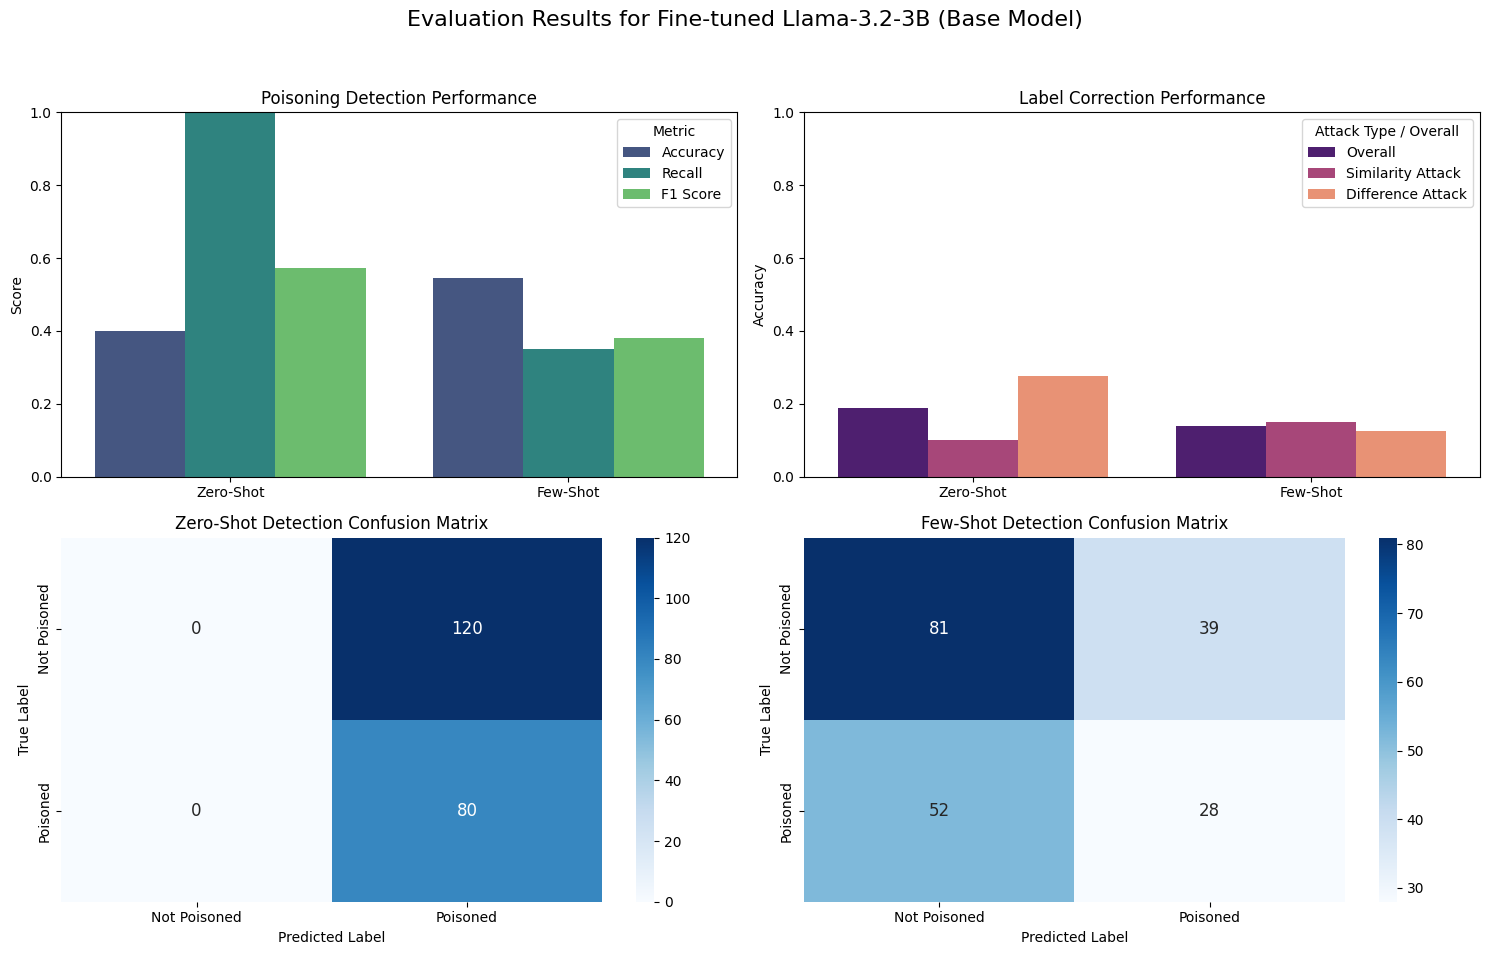

In [ ]:
# Cell 16: Visualize the results for Base Model

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported

# Set up the figure
plt.figure(figsize=(15, 10))
plt.suptitle('Evaluation Results for Fine-tuned Llama-3.2-3B (Base Model)', fontsize=16) # Overall title

# 1. Detection Performance
plt.subplot(2, 2, 1)
# Use the recalculated metrics
detection_data = {
    'Method': ['Zero-Shot', 'Few-Shot'],
    'Accuracy': [evaluation_report['detection']['zero_shot']['accuracy'], evaluation_report['detection']['few_shot']['accuracy']],
    'Recall': [evaluation_report['detection']['zero_shot']['recall'], evaluation_report['detection']['few_shot']['recall']],
    'F1 Score': [evaluation_report['detection']['zero_shot']['f1_score'], evaluation_report['detection']['few_shot']['f1_score']]
}
detection_df = pd.DataFrame(detection_data)
detection_df_melted = pd.melt(detection_df, id_vars=['Method'], var_name='Metric', value_name='Score')
sns.barplot(x='Method', y='Score', hue='Metric', data=detection_df_melted, palette='viridis')
plt.title('Poisoning Detection Performance')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('') # Remove redundant label

# 2. Correction Performance
plt.subplot(2, 2, 2)
# Use the recalculated metrics, handling potential None values if attacks didn't exist
correction_data = {
    'Method': ['Zero-Shot', 'Few-Shot'],
    'Overall': [evaluation_report['correction']['zero_shot'].get('correction_accuracy', 0), evaluation_report['correction']['few_shot'].get('correction_accuracy', 0)],
    'Similarity Attack': [evaluation_report['correction']['zero_shot'].get('similarity_attack_accuracy', 0), evaluation_report['correction']['few_shot'].get('similarity_attack_accuracy', 0)],
    'Difference Attack': [evaluation_report['correction']['zero_shot'].get('difference_attack_accuracy', 0), evaluation_report['correction']['few_shot'].get('difference_attack_accuracy', 0)]
}
correction_df = pd.DataFrame(correction_data)
correction_df_melted = pd.melt(correction_df, id_vars=['Method'], var_name='Attack Type / Overall', value_name='Accuracy')
sns.barplot(x='Method', y='Accuracy', hue='Attack Type / Overall', data=correction_df_melted, palette='magma')
plt.title('Label Correction Performance')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('') # Remove redundant label

# 3. Confusion Matrix for Zero-Shot Detection
plt.subplot(2, 2, 3)
cm_zero = confusion_matrix(eval_df['is_poisoned'], eval_df['is_poisoned_zero_shot_ft'])
sns.heatmap(cm_zero, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Poisoned', 'Poisoned'],
            yticklabels=['Not Poisoned', 'Poisoned'],
            annot_kws={"size": 12}) # Adjust annotation size
plt.title('Zero-Shot Detection Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 4. Confusion Matrix for Few-Shot Detection
plt.subplot(2, 2, 4)
cm_few = confusion_matrix(eval_df['is_poisoned'], eval_df['is_poisoned_few_shot_ft'])
sns.heatmap(cm_few, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Poisoned', 'Poisoned'],
            yticklabels=['Not Poisoned', 'Poisoned'],
            annot_kws={"size": 12}) # Adjust annotation size
plt.title('Few-Shot Detection Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
# Save the plot with the updated filename
PLOT_FILENAME_BASE = os.path.join(HOME, 'llama3.2-base_finetuned_evaluation.png')
plt.savefig(PLOT_FILENAME_BASE, dpi=300)
print(f"Evaluation plot saved to {PLOT_FILENAME_BASE}")
plt.show()


# Machine Learning

In [45]:
# Cell 1: Install Libraries and Mount Drive

# Install necessary libraries
!pip install xgboost pandas numpy scikit-learn matplotlib seaborn -q

import xgboost as xgb
import pandas as pd
import numpy as np
import os
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # Added OneHotEncoder
from sklearn.compose import ColumnTransformer # For handling mixed feature types easily
from sklearn.pipeline import Pipeline # For cleaner preprocessing
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch # To check for GPU availability

# Mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    # Handle case where Drive mount fails if needed

print(f"XGBoost version: {xgb.__version__}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
XGBoost version: 2.1.4


In [46]:
# Cell 2: Define Paths and Parameters

# --- Paths ---
# Define HOME path (adjust if your Drive structure is different)
HOME = '/content/drive/MyDrive/Motionsense Dataset/'
if not os.path.isdir(HOME):
    raise FileNotFoundError(f"HOME directory not found: {HOME}. Please ensure Drive is mounted and path is correct.")

CSV_PATH = os.path.join(HOME, 'combined_motionsense.csv') # Original full dataset

# --- Parameters ---
TRAIN_SIZE = 100000 # Number of samples for training set
TEST_SIZE = 20000  # Number of samples for evaluation set
TOTAL_SAMPLES = TRAIN_SIZE + TEST_SIZE
TARGET_POISON_RATE = 0.50 # Aim for balanced poisoned/clean overall before split

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# --- Data Columns ---
LABEL_COL = 'Label' # Original true label column name
REPORTED_LABEL_COL = 'reported_label' # Column we will create
POISON_FLAG_COL = 'is_poisoned' # Column we will create
ATTACK_TYPE_COL = 'attack_type' # Column we will create
ORIGINAL_LABEL_COL = 'original_label' # Column to store original label before poisoning
sensor_cols = [
    'attitude.roll','attitude.pitch','attitude.yaw',
    'gravity.x','gravity.y','gravity.z',
    'rotationRate.x','rotationRate.y','rotationRate.z',
    'userAcceleration.x','userAcceleration.y','userAcceleration.z'
]

print("Paths and parameters defined.")
print(f"Total samples to process: {TOTAL_SAMPLES}")


Paths and parameters defined.
Total samples to process: 120000


In [47]:
# Cell 3: Load Full Data and Define Poisoning Functions

# --- Load Full Dataset ---
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Original dataset not found at {CSV_PATH}.")
try:
    df_full = pd.read_csv(CSV_PATH)
    print(f"Successfully loaded original dataset. Shape: {df_full.shape}")
except Exception as e:
    raise RuntimeError(f"Failed to load or read CSV file at {CSV_PATH}: {e}")

# Basic data validation
if LABEL_COL not in df_full.columns:
     raise ValueError(f"Label column '{LABEL_COL}' not found in the dataset.")
if not all(col in df_full.columns for col in sensor_cols):
    missing_sensors = [col for col in sensor_cols if col not in df_full.columns]
    raise ValueError(f"Missing sensor columns: {missing_sensors}")

# Get unique labels
activity_labels = sorted(list(df_full[LABEL_COL].unique()))
print(f"Unique activity labels found: {activity_labels}")

# Check if dataset is large enough
if len(df_full) < TOTAL_SAMPLES:
    raise ValueError(f"Dataset size ({len(df_full)}) is smaller than the required total samples ({TOTAL_SAMPLES}).")


# --- Poisoning Functions ---
similar_pairs = {
    'WALKING': 'JOGGING', 'JOGGING': 'WALKING',
    'SITTING': 'STANDING', 'STANDING': 'SITTING',
    'UPSTAIRS': 'DOWNSTAIRS', 'DOWNSTAIRS': 'UPSTAIRS',
}

def poison_similarity(original_label, similar_pairs_map):
    return similar_pairs_map.get(original_label, original_label)

def poison_difference(original_label, all_labels):
    possible_labels = [l for l in all_labels if l != original_label]
    return random.choice(possible_labels) if possible_labels else original_label

def get_poisoned_label(original_label, attack_type, all_labels, similar_pairs_map):
    if attack_type == 'similarity':
        return poison_similarity(original_label, similar_pairs_map)
    elif attack_type == 'difference':
        return poison_difference(original_label, all_labels)
    else: # clean
        return original_label

print("Poisoning functions defined.")

Successfully loaded original dataset. Shape: (1412865, 14)
Unique activity labels found: ['downstairs', 'jogging', 'sitting', 'standing', 'upstairs', 'walking']
Poisoning functions defined.


In [48]:
# Cell 4: Sample Data and Apply Poisoning

print(f"Sampling {TOTAL_SAMPLES} rows from the full dataset...")
sampled_indices = np.random.choice(df_full.index, TOTAL_SAMPLES, replace=False)
df_sampled = df_full.loc[sampled_indices].copy()
df_sampled.reset_index(drop=True, inplace=True)

print(f"Applying poisoning logic to {TOTAL_SAMPLES} samples (target rate: {TARGET_POISON_RATE*100:.0f}%)...")

# Determine target number of poisoned samples
num_poisoned_total_target = int(TOTAL_SAMPLES * TARGET_POISON_RATE)

# Randomly select indices to poison
poison_indices = np.random.choice(df_sampled.index, num_poisoned_total_target, replace=False)

# Initialize new columns
df_sampled[ORIGINAL_LABEL_COL] = df_sampled[LABEL_COL] # Store original label
df_sampled[POISON_FLAG_COL] = False
df_sampled[REPORTED_LABEL_COL] = df_sampled[ORIGINAL_LABEL_COL]
df_sampled[ATTACK_TYPE_COL] = 'clean'

# Apply poisoning
poisoned_count = 0
for i, idx in enumerate(poison_indices):
    original = df_sampled.loc[idx, ORIGINAL_LABEL_COL]
    attack = 'similarity' if i % 2 == 0 else 'difference' # Alternate attack types
    poisoned_lbl = get_poisoned_label(original, attack, activity_labels, similar_pairs)

    if poisoned_lbl != original:
        df_sampled.loc[idx, REPORTED_LABEL_COL] = poisoned_lbl
        df_sampled.loc[idx, POISON_FLAG_COL] = True
        df_sampled.loc[idx, ATTACK_TYPE_COL] = attack
        poisoned_count += 1

print(f"Applied poisoning to {poisoned_count} samples ({poisoned_count/TOTAL_SAMPLES*100:.1f}% of total sampled).")
print("Value counts for poisoning flag:")
print(df_sampled[POISON_FLAG_COL].value_counts(normalize=True))

Sampling 120000 rows from the full dataset...
Applying poisoning logic to 120000 samples (target rate: 50%)...
Applied poisoning to 30000 samples (25.0% of total sampled).
Value counts for poisoning flag:
is_poisoned
False    0.75
True     0.25
Name: proportion, dtype: float64


In [49]:
# Cell 5: Perform Single Train/Test Split

print(f"Splitting data into Train ({TRAIN_SIZE}) and Test ({TEST_SIZE}) sets...")

# Calculate test_size fraction
test_fraction = TEST_SIZE / TOTAL_SAMPLES

# Split the entire dataframe to keep all columns aligned
train_df, test_df = train_test_split(
    df_sampled,
    test_size=test_fraction,
    random_state=SEED,
    stratify=df_sampled[POISON_FLAG_COL] # Stratify by poisoning flag
)

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Verify poisoning rate in each set
print(f"Poisoning rate in Training set: {train_df[POISON_FLAG_COL].mean():.3f}")
print(f"Poisoning rate in Test set: {test_df[POISON_FLAG_COL].mean():.3f}")

Splitting data into Train (100000) and Test (20000) sets...
Training set shape: (100000, 18)
Test set shape: (20000, 18)
Poisoning rate in Training set: 0.250
Poisoning rate in Test set: 0.250


In [50]:
# Cell 6: Preprocess Data for Detection Model

print("Preprocessing data for DETECTION model...")

# Define features (X) and target (y) for detection
y_detect_train = train_df[POISON_FLAG_COL].astype(int)
y_detect_test = test_df[POISON_FLAG_COL].astype(int)

# Features: sensor columns + reported_label (needs encoding)
detection_features = sensor_cols + [REPORTED_LABEL_COL]
X_detect_train_raw = train_df[detection_features]
X_detect_test_raw = test_df[detection_features]

# Create a preprocessor using ColumnTransformer
# OneHotEncode the categorical 'reported_label', pass through numerical sensor columns
# handle_unknown='ignore' will prevent errors if a rare category appears only in test
preprocessor_detect = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', sensor_cols),
        ('cat', OneHotEncoder(categories=[activity_labels], handle_unknown='ignore', sparse_output=False), [REPORTED_LABEL_COL])
    ],
    remainder='drop' # Drop any columns not specified
)

# Fit the preprocessor on the training data and transform both sets
X_detect_train = preprocessor_detect.fit_transform(X_detect_train_raw)
X_detect_test = preprocessor_detect.transform(X_detect_test_raw)

# Get feature names after transformation for potential use later
feature_names_detect = preprocessor_detect.get_feature_names_out()

print(f"Detection Training Features shape: {X_detect_train.shape}")
print(f"Detection Test Features shape: {X_detect_test.shape}")
# print("Detection Feature Names:", feature_names_detect) # Optional: view names
print("Preprocessing for detection complete.")

Preprocessing data for DETECTION model...
Detection Training Features shape: (100000, 18)
Detection Test Features shape: (20000, 18)
Preprocessing for detection complete.


In [51]:
# Cell 7: Train XGBoost Detection Model

print("--- Training DETECTION Model ---")

# Check for GPU
if torch.cuda.is_available():
    print("GPU detected. Using 'gpu_hist'.")
    tree_method = 'gpu_hist'
else:
    print("No GPU detected. Using 'hist'.")
    tree_method = 'hist'

# Configure XGBoost model for detection (binary classification)
xgb_detector = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    tree_method=tree_method
)

# --- Measure Training Time ---
print("Starting detection model training...")
start_time_detect = time.time()

xgb_detector.fit(X_detect_train, y_detect_train)

end_time_detect = time.time()
training_time_detect = end_time_detect - start_time_detect
print(f"Detection model training finished in {training_time_detect:.2f} seconds.")

# --- Check Time Constraint ---
max_training_time = 20 * 60 # 20 minutes
if training_time_detect > max_training_time:
    print(f"WARNING: Detection training time ({training_time_detect:.2f}s) exceeded the {max_training_time/60:.0f}-minute limit!")
else:
    print(f"Detection training completed within the {max_training_time/60:.0f}-minute time limit.")

--- Training DETECTION Model ---
No GPU detected. Using 'hist'.
Starting detection model training...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:00:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Detection model training finished in 5.38 seconds.
Detection training completed within the 20-minute time limit.


In [52]:
# Cell 8: Evaluate Detection Model and Store Predictions

print("Evaluating DETECTION model on the test set...")

# Make predictions on the test set
y_pred_detect_test = xgb_detector.predict(X_detect_test)
# y_pred_proba_detect_test = xgb_detector.predict_proba(X_detect_test)[:, 1] # Optional: get probabilities

# Store predictions back into the original test_df for later use
test_df['detected_poisoned'] = y_pred_detect_test

# Calculate Metrics for Detection
accuracy_detect = accuracy_score(y_detect_test, y_pred_detect_test)
recall_detect = recall_score(y_detect_test, y_pred_detect_test, zero_division=0)
f1_detect = f1_score(y_detect_test, y_pred_detect_test, zero_division=0)
cm_detect = confusion_matrix(y_detect_test, y_pred_detect_test)
cr_detect = classification_report(y_detect_test, y_pred_detect_test, target_names=['Not Poisoned (0)', 'Poisoned (1)'], zero_division=0)

# --- Report Detection Results ---
print("\n--- XGBoost Poisoning DETECTION Evaluation Results ---")
print(f"Test Set Size: {len(y_detect_test)}")
print(f"Actual Poisoned Samples in Test Set: {y_detect_test.sum()}")
print("-" * 50)
print(f"Accuracy: {accuracy_detect:.4f}")
print(f"Recall (Sensitivity for Poisoned): {recall_detect:.4f}")
print(f"F1 Score (for Poisoned): {f1_detect:.4f}")
print("-" * 50)
print("Confusion Matrix (TN, FP / FN, TP):\n", cm_detect)
print("-" * 50)
print("Classification Report:\n", cr_detect)
print("-" * 50)

Evaluating DETECTION model on the test set...

--- XGBoost Poisoning DETECTION Evaluation Results ---
Test Set Size: 20000
Actual Poisoned Samples in Test Set: 5000
--------------------------------------------------
Accuracy: 0.9326
Recall (Sensitivity for Poisoned): 0.7750
F1 Score (for Poisoned): 0.8519
--------------------------------------------------
Confusion Matrix (TN, FP / FN, TP):
 [[14778   222]
 [ 1125  3875]]
--------------------------------------------------
Classification Report:
                   precision    recall  f1-score   support

Not Poisoned (0)       0.93      0.99      0.96     15000
    Poisoned (1)       0.95      0.78      0.85      5000

        accuracy                           0.93     20000
       macro avg       0.94      0.88      0.90     20000
    weighted avg       0.93      0.93      0.93     20000

--------------------------------------------------


In [53]:
# Cell 9: Preprocess Data for Sanitization Model

print("Preprocessing data for SANITIZATION model...")

# Target: Original activity label (needs label encoding)
# Use LabelEncoder for multi-class target
label_encoder_sani = LabelEncoder()
# Fit on the original labels from the TRAINING set to learn the mapping
y_sani_train = label_encoder_sani.fit_transform(train_df[ORIGINAL_LABEL_COL])
# Transform the test set labels using the SAME fitted encoder
y_sani_test = label_encoder_sani.transform(test_df[ORIGINAL_LABEL_COL])

# Store mapping for later decoding
label_mapping = dict(zip(label_encoder_sani.classes_, label_encoder_sani.transform(label_encoder_sani.classes_)))
print("Label Encoding Mapping for Sanitization Target:", label_mapping)
num_classes = len(label_mapping)
print(f"Number of classes for sanitization: {num_classes}")

# Features: Sensor columns ONLY
X_sani_train = train_df[sensor_cols].values # Use .values to get numpy array
X_sani_test = test_df[sensor_cols].values

print(f"Sanitization Training Features shape: {X_sani_train.shape}")
print(f"Sanitization Test Features shape: {X_sani_test.shape}")
print(f"Sanitization Training Target shape: {y_sani_train.shape}")
print(f"Sanitization Test Target shape: {y_sani_test.shape}")
print("Preprocessing for sanitization complete.")

Preprocessing data for SANITIZATION model...
Label Encoding Mapping for Sanitization Target: {'downstairs': np.int64(0), 'jogging': np.int64(1), 'sitting': np.int64(2), 'standing': np.int64(3), 'upstairs': np.int64(4), 'walking': np.int64(5)}
Number of classes for sanitization: 6
Sanitization Training Features shape: (100000, 12)
Sanitization Test Features shape: (20000, 12)
Sanitization Training Target shape: (100000,)
Sanitization Test Target shape: (20000,)
Preprocessing for sanitization complete.


In [54]:
# Cell 10: Train XGBoost Sanitization Model

print("--- Training SANITIZATION Model ---")

# Check for GPU (reuse variable from detection)
if 'tree_method' not in globals(): tree_method = 'hist' # Default if detection cell wasn't run

# Configure XGBoost model for sanitization (multi-class classification)
# Note: objective is 'multi:softprob' (outputs probabilities per class) or 'multi:softmax' (outputs predicted class)
# Using softmax here for direct prediction. softprob is useful if you need probabilities.
xgb_sanitizer = xgb.XGBClassifier(
    objective='multi:softmax',     # Multi-class classification
    num_class=num_classes,         # Number of activity classes
    eval_metric='mlogloss',        # Multi-class logloss
    use_label_encoder=False,
    n_estimators=250,              # Might need more estimators for multi-class
    learning_rate=0.1,
    max_depth=7,                   # Might need slightly deeper trees
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    tree_method=tree_method
)

# --- Measure Training Time ---
print("Starting sanitization model training...")
start_time_sani = time.time()

xgb_sanitizer.fit(X_sani_train, y_sani_train)

end_time_sani = time.time()
training_time_sani = end_time_sani - start_time_sani
print(f"Sanitization model training finished in {training_time_sani:.2f} seconds.")

# --- Check Time Constraint ---
max_training_time_sani = 20 * 60 # 20 minutes
if training_time_sani > max_training_time_sani:
    print(f"WARNING: Sanitization training time ({training_time_sani:.2f}s) exceeded the {max_training_time_sani/60:.0f}-minute limit!")
else:
    print(f"Sanitization training completed within the {max_training_time_sani/60:.0f}-minute time limit.")

--- Training SANITIZATION Model ---
Starting sanitization model training...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:00:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Sanitization model training finished in 26.95 seconds.
Sanitization training completed within the 20-minute time limit.


In [55]:
# Cell 11: Evaluate Sanitization and End-to-End Performance

print("Evaluating SANITIZATION model and End-to-End performance...")

# 1. Get Sanitizer Predictions for the test set
y_pred_sani_encoded = xgb_sanitizer.predict(X_sani_test)
# Decode predictions back to original labels
y_pred_sani_labels = label_encoder_sani.inverse_transform(y_pred_sani_encoded)

# Store sanitizer predictions in the test_df
test_df['sanitized_label_pred'] = y_pred_sani_labels

# 2. Determine the Final Label based on Detection + Sanitization
# If detected_poisoned is 1 (True), use sanitized_label_pred
# Otherwise, use the original reported_label
test_df['final_label'] = np.where(
    test_df['detected_poisoned'] == 1, # Condition based on detector output
    test_df['sanitized_label_pred'],   # Value if True (use sanitizer output)
    test_df[REPORTED_LABEL_COL]        # Value if False (use reported label)
)

# 3. Evaluate End-to-End Accuracy
# Compare the 'final_label' against the true 'original_label'
y_true_final = test_df[ORIGINAL_LABEL_COL]
y_pred_final = test_df['final_label']

accuracy_final = accuracy_score(y_true_final, y_pred_final)
f1_final_weighted = f1_score(y_true_final, y_pred_final, average='weighted', zero_division=0)
cr_final = classification_report(y_true_final, y_pred_final, labels=activity_labels, zero_division=0)

print("\n--- End-to-End Performance (Detection + Sanitization) ---")
print(f"Final Accuracy (comparing final predicted label vs true original label): {accuracy_final:.4f}")
print(f"Final F1 Score (Weighted): {f1_final_weighted:.4f}")
print("\nFinal Classification Report (End-to-End):\n", cr_final)
print("-" * 50)

# 4. Evaluate Sanitizer Accuracy Specifically on Correctly Detected Poisoned Samples
correctly_detected_poisoned_df = test_df[
    (test_df[POISON_FLAG_COL] == True) & # Actually poisoned
    (test_df['detected_poisoned'] == 1)  # AND detected as poisoned
].copy()

num_correctly_detected = len(correctly_detected_poisoned_df)

if num_correctly_detected > 0:
    sanitizer_accuracy_on_detected = accuracy_score(
        correctly_detected_poisoned_df[ORIGINAL_LABEL_COL], # True original label
        correctly_detected_poisoned_df['sanitized_label_pred'] # Sanitizer's prediction
    )
    print(f"Sanitizer Accuracy on the {num_correctly_detected} correctly detected poisoned samples: {sanitizer_accuracy_on_detected:.4f}")
else:
    print("No poisoned samples were correctly detected, cannot calculate specific sanitizer accuracy.")
print("-" * 50)

# Optional: Save test_df with all predictions
# final_results_path = os.path.join(HOME, 'xgb_final_results.csv')
# test_df.to_csv(final_results_path, index=False)
# print(f"Test dataframe with all predictions saved to {final_results_path}")

Evaluating SANITIZATION model and End-to-End performance...

--- End-to-End Performance (Detection + Sanitization) ---
Final Accuracy (comparing final predicted label vs true original label): 0.9162
Final F1 Score (Weighted): 0.9162

Final Classification Report (End-to-End):
               precision    recall  f1-score   support

  downstairs       0.80      0.79      0.79      1871
     jogging       0.87      0.84      0.85      1892
     sitting       1.00      1.00      1.00      4802
    standing       0.99      0.99      0.99      4325
    upstairs       0.81      0.84      0.82      2274
     walking       0.88      0.89      0.89      4836

    accuracy                           0.92     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.92      0.92      0.92     20000

--------------------------------------------------
Sanitizer Accuracy on the 3875 correctly detected poisoned samples: 0.9105
--------------------------------------------------


In [56]:
# Cell 12: Comprehensive Evaluation Report

import numpy as np # Ensure numpy is imported for calculations

print("\n" + "="*60)
print(" Comprehensive XGBoost Detection & Sanitization Report")
print("="*60)

# --- 1. Dataset Information ---
print("\n--- 1. Dataset Configuration ---")
try:
    print(f"Total Samples Processed : {TOTAL_SAMPLES}")
    print(f"Training Set Size       : {TRAIN_SIZE} ({len(train_df)} actual)")
    print(f"Test Set Size           : {TEST_SIZE} ({len(test_df)} actual)")
    # Recalculate rates for clarity
    train_poison_rate = train_df[POISON_FLAG_COL].mean()
    test_poison_rate = test_df[POISON_FLAG_COL].mean()
    print(f"Poisoning Rate (Train)  : {train_poison_rate:.3f}")
    print(f"Poisoning Rate (Test)   : {test_poison_rate:.3f}")
    print(f"Activity Labels         : {activity_labels}")
except NameError as e:
    print(f"Error accessing dataset info variables: {e}. Ensure Cells 2-5 ran.")
except Exception as e:
    print(f"An unexpected error occurred accessing dataset info: {e}")


# --- 2. Detection Model Performance ---
print("\n--- 2. Poisoning Detection Model (XGBoost) ---")
try:
    print(f"Training Time           : {training_time_detect:.2f} seconds")
    print(f"\nPerformance on Test Set ({len(y_detect_test)} samples):")
    print(f"  Accuracy              : {accuracy_detect:.4f}")
    print(f"  Recall (Poisoned)     : {recall_detect:.4f}")
    print(f"  F1 Score (Poisoned)   : {f1_detect:.4f}")
    print("\n  Confusion Matrix (TN, FP / FN, TP):")
    if 'cm_detect' in globals() and cm_detect.shape == (2, 2):
        print(f"  [[{cm_detect[0,0]:>5d} {cm_detect[0,1]:>5d}]")
        print(f"   [{cm_detect[1,0]:>5d} {cm_detect[1,1]:>5d}]]")
    elif 'cm_detect' in globals():
         print(f"  {cm_detect}")
    else:
         print("  Confusion Matrix not available.")
    print("\n  Classification Report:")
    print(cr_detect)
except NameError as e:
    print(f"Error accessing detection model variables: {e}. Ensure Cells 7-8 ran.")
except Exception as e:
    print(f"An unexpected error occurred accessing detection results: {e}")


# --- 3. Sanitization Model Performance ---
print("\n--- 3. Label Sanitization Model (XGBoost) ---")
try:
    print(f"Training Time           : {training_time_sani:.2f} seconds")

    # Evaluate sanitizer accuracy on ALL actually poisoned samples in the test set
    poisoned_test_samples = test_df[test_df[POISON_FLAG_COL] == True]
    num_poisoned_test = len(poisoned_test_samples)

    if num_poisoned_test > 0:
        sanitizer_accuracy_overall_poisoned = accuracy_score(
            poisoned_test_samples[ORIGINAL_LABEL_COL],
            poisoned_test_samples['sanitized_label_pred']
        )
        print(f"\nSanitizer Accuracy (on all {num_poisoned_test} actual poisoned samples): {sanitizer_accuracy_overall_poisoned:.4f}")
    else:
        print("\nNo poisoned samples in test set to evaluate overall sanitizer accuracy.")

    # Report accuracy on correctly detected poisoned samples (calculated in Cell 11)
    if 'num_correctly_detected' in globals():
        if num_correctly_detected > 0:
             print(f"Sanitizer Accuracy (on {num_correctly_detected} correctly DETECTED poisoned samples): {sanitizer_accuracy_on_detected:.4f}")
        else:
             print("Sanitizer Accuracy (on correctly DETECTED poisoned samples): N/A (None were correctly detected)")
    else:
        print("Sanitizer Accuracy (on correctly DETECTED poisoned samples): Variable not found.")

except NameError as e:
    print(f"Error accessing sanitization model variables: {e}. Ensure Cells 10-11 ran.")
except Exception as e:
    print(f"An unexpected error occurred accessing sanitization results: {e}")


# --- 4. End-to-End System Performance ---
print("\n--- 4. End-to-End System Performance (Detection + Sanitization Logic) ---")
try:
    print(f"Evaluated on {len(test_df)} test samples.")
    print(f"Final Accuracy (vs Original Label): {accuracy_final:.4f}")
    print(f"Final F1 Score (Weighted)       : {f1_final_weighted:.4f}")
    print("\nFinal Classification Report (End-to-End):\n", cr_final)
    # Add a note about how the final label was derived
    print("\nNote: Final label uses sanitizer prediction if detector flagged sample as poisoned,")
    print("      otherwise uses the originally reported (potentially poisoned) label.")

except NameError as e:
    print(f"Error accessing end-to-end variables: {e}. Ensure Cell 11 ran.")
except Exception as e:
    print(f"An unexpected error occurred accessing end-to-end results: {e}")

print("\n" + "="*60)
print(" End of Report")
print("="*60)


 Comprehensive XGBoost Detection & Sanitization Report

--- 1. Dataset Configuration ---
Total Samples Processed : 120000
Training Set Size       : 100000 (100000 actual)
Test Set Size           : 20000 (20000 actual)
Poisoning Rate (Train)  : 0.250
Poisoning Rate (Test)   : 0.250
Activity Labels         : ['downstairs', 'jogging', 'sitting', 'standing', 'upstairs', 'walking']

--- 2. Poisoning Detection Model (XGBoost) ---
Training Time           : 5.38 seconds

Performance on Test Set (20000 samples):
  Accuracy              : 0.9326
  Recall (Poisoned)     : 0.7750
  F1 Score (Poisoned)   : 0.8519

  Confusion Matrix (TN, FP / FN, TP):
  [[14778   222]
   [ 1125  3875]]

  Classification Report:
                  precision    recall  f1-score   support

Not Poisoned (0)       0.93      0.99      0.96     15000
    Poisoned (1)       0.95      0.78      0.85      5000

        accuracy                           0.93     20000
       macro avg       0.94      0.88      0.90     20000